In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch.utils.data as Data
import optuna
import optuna.trial
import os 

In [2]:
import pandas_profiling as ppf
data = pd.read_csv('./data/train_data_3.csv')
data=data.drop_duplicates(subset='x')
# ppf.ProfileReport(data)
data

,x,y,R
0,0.169509,-10.495672,0.7
1,0.171749,-10.056267,0.7
2,0.174885,-9.569808,0.7
3,0.177126,-9.385051,0.7
4,0.180390,-9.052903,0.7
...,...,...,...
292,1.913537,-4.968518,-1.0
293,1.926978,-4.918350,-1.0
294,1.940420,-4.847422,-1.0
295,1.953861,-4.752275,-1.0


In [3]:


# 分割训练集和测试集



x = data.iloc[:, [0,2]].values
y = data.iloc[:, 1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 数据标准化
ss1 = preprocessing.StandardScaler()
x_train = ss1.fit_transform(x_train)
x_test = ss1.transform(x_test)
x_total=ss1.transform(x)


y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train-y_mean)/y_std
y_test=(y_test-y_mean)/y_std

# numpy转tensor
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float().view(-1,1)
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float().view(-1,1)
x_total=torch.from_numpy(x_total).float()

# batch_size = 64

# print(next(iter(loader)))


In [4]:
class LR(nn.Module):

    def __init__(self,trial):
        super(LR, self).__init__()
        fc1_out=trial.suggest_int("fc1_out", 8, 128,8)
        self.fc1 = nn.Linear(2, fc1_out)
        fc2_out=trial.suggest_int("fc2_out", 8, 128,8)
        self.fc2 = nn.Linear(fc1_out, fc2_out)
        fc3_out=trial.suggest_int("fc3_out", 8, 64,8)
        self.fc3= nn.Linear(fc2_out, fc3_out)
        self.fc4= nn.Linear(fc3_out, 1)
        activefunct=trial.suggest_categorical("activefunct", ["relu", "sigmoid","tanh"])
        self.sigmoid=getattr(torch,activefunct)
    def forward(self, x):
        x = self.sigmoid((self.fc1(x)))
        x = self.sigmoid((self.fc2(x)))
        x=self.sigmoid((self.fc3(x)))
        x = self.fc4(x)
        return x

In [5]:
epochs=3000

In [6]:

def objective(trial):
    torch_dataset = Data.TensorDataset(x_train, y_train) 
    batch_size = trial.suggest_int("batch_size", 1, 16)
    loader = Data.DataLoader(dataset=torch_dataset,batch_size=8,shuffle=True) 
    
    net=LR(trial)
    criterion = nn.MSELoss()

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "Adadelta","Adagrad","RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1,log=True)
    weight_decay=trial.suggest_float("weight_decay",1e-3,1e-1,log=True)
    optimizer = getattr(optim, optimizer_name)(net.parameters(), lr=lr,weight_decay=weight_decay) 

    # momentum= trial.suggest_float('momentum',0,1,step=0.01)
    # optimizer=optim.RMSprop(net.parameters(), lr=lr,weight_decay=weight_decay,momentum=momentum)
    epochs_list=[]
    train_loss_list=[]
    test_error_list=[]
    for e in range(epochs):
        epochs_list.append(e)
        net.train()
        for i, (batch_x, batch_y) in enumerate(loader):
            y_hat = net(batch_x)
    #         print(y_hat.shape)
            
            loss = criterion(y_hat, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        net.eval()
        with torch.no_grad():
            y_pred_train= net(x_train)
            loss = criterion(y_pred_train, y_train)
            train_loss_list.append(loss.item())
            
            y_pred_test = net(x_test)
            error = criterion(y_pred_test, y_test)
            test_error_list.append(error.item())
            # if (e+1)%50==0:
            #     print("Epoch:{}, trainLoss:{}，testLoss:{}".format(e+1,loss.item(),error.item()))

        trial.report(error,e)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return error


In [7]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)


[I 2022-10-25 16:43:26,749] A new study created in memory with name: no-name-ec550d8b-3fb3-4d6d-8986-5e0971c95930
[W 2022-10-25 16:52:59,537] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "c:\Users\86189\anaconda3\envs\pythonProject\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\86189\AppData\Local\Temp\ipykernel_1864\2967934960.py", line 22, in objective
    for i, (batch_x, batch_y) in enumerate(loader):
  File "c:\Users\86189\anaconda3\envs\pythonProject\lib\site-packages\torch\utils\data\dataloader.py", line 681, in __next__
    data = self._next_data()
  File "c:\Users\86189\anaconda3\envs\pythonProject\lib\site-packages\torch\utils\data\dataloader.py", line 721, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "c:\Users\86189\anaconda3\envs\pythonProject\lib\site-packages\torch\utils\data\_utils\fetch

KeyboardInterrupt: 

In [8]:

trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

ValueError: No trials are completed yet.

In [ ]:
import csv
trial={'batch_size': 10, 'fc1_out': 48, 'fc2_out': 8, 'fc3_out': 24, 'activefunct': 'relu', 'optimizer': 'RMSprop', 'lr': 0.00040792019515367977, 'weight_decay': 0.0010319587736834876}
with open('best_param.csv', 'a',newline='') as f:  
    writer = csv.writer(f)
    writer.writerow(['', ''])
    for k, v in trial.items():
        writer.writerow([k, v])

In [4]:

valid_data=pd.read_csv('./data/test_data_3.csv').values
valid_data_target=valid_data[:,[0,2]]
valid_data_y=valid_data[:,1]

x_valid=ss1.transform(valid_data_target)
x_valid = torch.from_numpy(x_valid).float()

y_valid = torch.from_numpy(valid_data_y).float().view(-1,1)
y_valid=(y_valid-y_mean)/y_std


NameError: name 'ss1' is not defined

In [ ]:

import matplotlib.pyplot as plt
def valid(trial):
    
    torch_dataset = Data.TensorDataset(x_train, y_train) 
    batch_size = trial.suggest_int("batch_size", 1, 16)
    loader = Data.DataLoader(dataset=torch_dataset,batch_size=batch_size,shuffle=True) 
    
    net=LR(trial)
    criterion = nn.MSELoss()
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "Adadelta","Adagrad","RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1,log=True)
    weight_decay=trial.suggest_float("weight_decay",1e-3,1e-1,log=True)
    optimizer = getattr(optim, optimizer_name)(net.parameters(), lr=lr,weight_decay=weight_decay) 

    epochs_list=[]
    train_loss_list=[]
    test_error_list=[]
    valid_error_list=[]
    for e in range(epochs):
        epochs_list.append(e)
        net.train()
        for i, (batch_x, batch_y) in enumerate(loader):
            y_hat = net(batch_x)
    #         print(y_hat.shape)
            
            loss = criterion(y_hat, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        net.eval()
        with torch.no_grad():
            y_pred_train= net(x_train)
            loss = criterion(y_pred_train, y_train)
            train_loss_list.append(loss.item())
            
            y_pred_test = net(x_test)
            test_error = criterion(y_pred_test, y_test)
            test_error_list.append(test_error.item())

            y_pred_valid=net(x_valid)
            valid_error = criterion(y_pred_valid, y_valid)
            valid_error_list.append(valid_error.item())

            if (e+1)%50==0:
                print("Epoch:{}, trainLoss:{}，testLoss:{},ValidLoss:{}".format(e+1,loss.item(),test_error.item(),valid_error.item()))
    
    plt.figure()
    plt.xlabel("Training epochs")
    plt.ylabel("error")
    plt.grid()
    plt.plot(epochs_list, train_loss_list, '.-', color="r",
                    label="train_loss")
    plt.plot(epochs_list, test_error_list, '.-', color="g",
                    label="test_error")
    plt.plot(epochs_list, valid_error_list, '.-', color="b",
                    label="valid_error")
    plt.legend(loc="best")
    
    net.eval()
    y_pred=net(x_total)
    y_pred=y_pred.data.numpy()
    y_pred=y_pred*y_std+y_mean

    y_pred_valid=net(x_valid)
    y_pred_valid=y_pred_valid.data.numpy()
    y_pred_valid=y_pred_valid*y_std+y_mean

    x_axis=data.iloc[:,0].values

    plt.figure(figsize=(15,8))
    plt.scatter(x_axis,y_pred,s=50,c="b",label='train_pred')
    plt.scatter(x_axis,y,s=50,c="g",label='train')

    x_axis_valid=valid_data[:,0]
    plt.scatter(x_axis_valid,y_pred_valid,s=50,c="c",label='valid_pred')
    plt.scatter(x_axis_valid,valid_data_y,s=50,c="r",label='valid')
    plt.grid()
    plt.legend()
    plt.xlim(0,2)
    plt.ylim(-13,-4)
    return None

Epoch:50, trainLoss:0.06392897665500641，testLoss:0.0427309051156044,ValidLoss:0.057707011699676514
Epoch:100, trainLoss:0.027719439938664436，testLoss:0.017960907891392708,ValidLoss:0.062258221209049225
Epoch:150, trainLoss:0.023789653554558754，testLoss:0.012946924194693565,ValidLoss:0.03588965907692909
Epoch:200, trainLoss:0.021886276081204414，testLoss:0.01056702621281147,ValidLoss:0.028443895280361176
Epoch:250, trainLoss:0.03405964747071266，testLoss:0.01762649044394493,ValidLoss:0.019574405625462532
Epoch:300, trainLoss:0.026045531034469604，testLoss:0.018042825162410736,ValidLoss:0.026756253093481064
Epoch:350, trainLoss:0.02124197594821453，testLoss:0.011966122314333916,ValidLoss:0.021037917584180832
Epoch:400, trainLoss:0.019600598141551018，testLoss:0.010442105121910572,ValidLoss:0.02110947296023369
Epoch:450, trainLoss:0.020092081278562546，testLoss:0.009237616322934628,ValidLoss:0.022596288472414017
Epoch:500, trainLoss:0.019500980153679848，testLoss:0.008479228243231773,ValidLoss:0

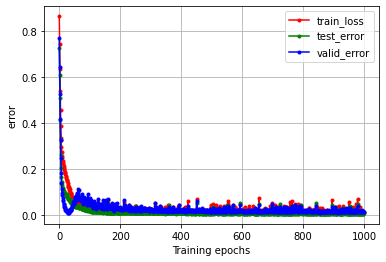

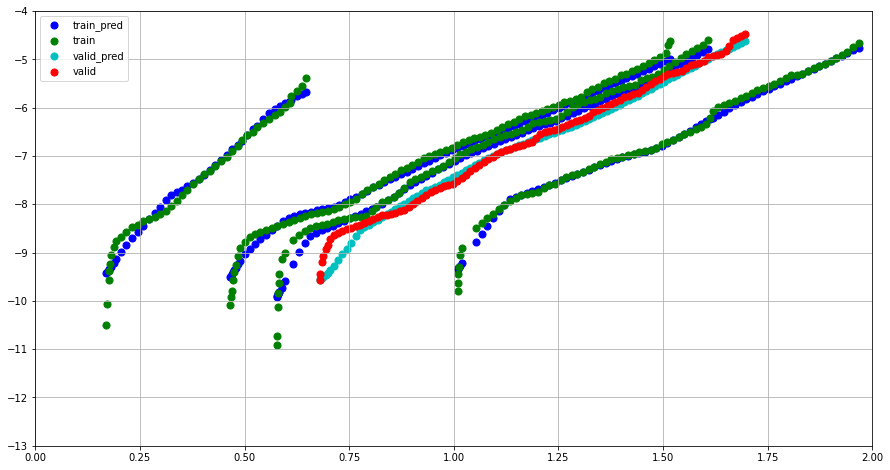

In [ ]:
valid(trial)